In [1]:
#import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from abc import ABC, abstractmethod
import pickle
from sklearn.preprocessing import StandardScaler

## Utils
ReLU, Softmax, CrossEntropy

In [2]:
def plot_training_logs(logs):
    epochs = range(1, len(logs['train_loss']) + 1)

    # Create subplots in a 2x2 grid
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    
    # Plot train loss
    axs[0, 0].plot(epochs, logs['train_loss'], label='Train Loss', color='blue')
    axs[0, 0].set_title('Training Loss')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend()

    # Plot train accuracy
    axs[0, 1].plot(epochs, logs['train_accuracy'], label='Train Accuracy', color='green')
    axs[0, 1].set_title('Training Accuracy')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].set_ylabel('Accuracy')
    axs[0, 1].legend()

    # Plot validation loss
    if logs['validation_f1']:
        axs[1, 0].plot(epochs, logs['validation_f1'], label='Validation f1', color='orange')
        axs[1, 0].set_title('Validation f1')
        axs[1, 0].set_xlabel('Epoch')
        axs[1, 0].set_ylabel('Loss')
        axs[1, 0].legend()

    # Plot validation accuracy
    if logs['validation_accuracy']:
        axs[1, 1].plot(epochs, logs['validation_accuracy'], label='Validation Accuracy', color='red')
        axs[1, 1].set_title('Validation Accuracy')
        axs[1, 1].set_xlabel('Epoch')
        axs[1, 1].set_ylabel('Accuracy')
        axs[1, 1].legend()

    plt.tight_layout()
    plt.show()

In [3]:
# ReLU activation function
class ReLU:
    def forward(self, x, is_training=True):
        self.X = x
        return np.where(x > 0, x, 0)
    
    def backward(self, grad, learning_rate):
        return grad * np.where(self.X > 0, 1, 0)

In [4]:
class Softmax:
    def __init__(self):
        self.output = None

    def forward(self, x, is_training=True):
        exp_x = np.exp(x - np.max(x, axis=0, keepdims=True))
        self.output = exp_x / np.sum(exp_x, axis=0, keepdims=True)
        return self.output
    
    def backward(self, grad, learning_rate):
        return grad

In [5]:
def cross_entropy_loss(y, y_hat):
    return -np.mean(y * np.log(y_hat + 1e-10))

## Building Blocks of Neural Networks

In [6]:
class DenseLayer:

    def __init__(self, prev_neurons=1, neurons=1):
        self.W = np.random.randn(neurons, prev_neurons) *  np.sqrt(2 / prev_neurons)
        self.b = np.zeros((neurons, 1))
        self.neurons = neurons
        self.prev_neurons = prev_neurons
        self.dW = None
        self.db = None
        
    def forward(self, X, is_training=True):
        self.X = X
        self.Z =  self.W @ X + self.b
        return self.Z
    
    def add_optimizer(self):
        self.optimizer = True
        
        
    def backward(self, dZ, learning_rate, optimizer=None):
        m = self.X.shape[1]
        self.dW = (dZ @ self.X.T) / m
        self.db = np.sum(dZ, axis=1, keepdims=True) / m
        
        if not optimizer:
            self.W -= learning_rate * self.dW
            self.b -= learning_rate * self.db

        return self.W.T @ dZ
    
    def save(self):
        return self.W, self.b
    
    def load(self, params):
        self.W = params[0]
        self.b = params[1]
        self.neurons = self.W.shape[1]
        self.prev_neurons = self.W.shape[0]

    

In [7]:
class Dropout:
    def __init__(self, keep_prob=0.8):
        self.keep_prob = keep_prob
        self.mask = None
    
    def forward(self, X, is_training=True):
        if is_training:
            self.mask = np.random.rand(*X.shape) < self.keep_prob
            self.mask = self.mask / self.keep_prob
            return X * self.mask
        else:
            return X
    
    def backward(self, dA, learning_rate):
        return dA * self.mask


In [8]:
class BatchNormalization:
    def __init__(self, neurons, momentum=0.9):
        self.gamma = np.ones((neurons, 1))
        self.beta = np.zeros((neurons, 1))
        self.episilon = 1e-15
        self.momentum = momentum
        self.running_mean = np.zeros((neurons, 1))
        self.running_var = np.zeros((neurons, 1))
        
    def forward(self, X, is_training=True):
        if is_training:
            self.x = X
            self.mean = np.mean(X, axis=1, keepdims=True)
            self.var = np.var(X, axis=1, keepdims=True)
            self.X_norm = (X - self.mean) / np.sqrt(self.var + self.episilon)
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * self.mean
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * self.var
        else:
            self.X_norm = (X - self.running_mean) / np.sqrt(self.running_var + self.episilon)
        return self.gamma * self.X_norm + self.beta
    
    def backward(self, dA, learning_rate):
        m = self.x.shape[1]
        dgamma = np.sum(dA * self.X_norm, axis=1, keepdims=True) / m
        dbeta = np.sum(dA, axis=1, keepdims=True) / m

        dX_norm = dA * self.gamma
        dvar = np.sum(dX_norm * (self.x - self.mean) * -0.5 * np.power(self.var + self.episilon, -1.5), axis=1, keepdims=True)
        dmean = np.sum(dX_norm * -1 / np.sqrt(self.var + self.episilon), axis=1, keepdims=True) + dvar * np.sum(-2 * (self.x - self.mean), axis=1, keepdims=True) / m
        
        dX = dX_norm / np.sqrt(self.var + self.episilon) + dvar * 2 * (self.x - self.mean) / m + dmean / m
        
        self.gamma -= learning_rate * dgamma
        self.beta -= learning_rate * dbeta
        
        return dX
    
    def save(self):
        return self.gamma, self.beta, self.running_mean, self.running_var
    
    def load(self, params):
        self.gamma, self.beta, self.running_mean, self.running_var = params

In [9]:
class AdamOptimizer:
    def __init__(self, layers, learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.learning_rate = learning_rate
        self.layers = layers
        self.m_w = [np.zeros_like(layer.W) for layer in layers if isinstance(layer, DenseLayer)]
        self.v_w = [np.zeros_like(layer.W) for layer in layers if isinstance(layer, DenseLayer)]
        self.m_b = [np.zeros_like(layer.b) for layer in layers if isinstance(layer, DenseLayer)]
        self.v_b = [np.zeros_like(layer.b) for layer in layers if isinstance(layer, DenseLayer)]
        self.t = 0

        for layer in layers:
            if isinstance(layer, DenseLayer):
                layer.add_optimizer()

    def update(self):
        self.t += 1
        i = 0
        for layer in self.layers:
            if isinstance(layer, DenseLayer):
                self.m_w[i] = self.beta1 * self.m_w[i] + (1 - self.beta1) * layer.dW
                self.v_w[i] = self.beta2 * self.v_w[i] + (1 - self.beta2) * layer.dW**2
                m_w_hat = self.m_w[i] / (1 - self.beta1**self.t)
                v_w_hat = self.v_w[i] / (1 - self.beta2**self.t)
                layer.W -= self.learning_rate * m_w_hat / (np.sqrt(v_w_hat) + self.epsilon)

                self.m_b[i] = self.beta1 * self.m_b[i] + (1 - self.beta1) * layer.db
                self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * layer.db**2
                m_b_hat = self.m_b[i] / (1 - self.beta1**self.t)
                v_b_hat = self.v_b[i] / (1 - self.beta2**self.t)
                layer.b -= self.learning_rate * m_b_hat / (np.sqrt(v_b_hat) + self.epsilon)

                i += 1


## Neural Network

In [10]:
class NeuralNetwork:
    def __init__(self):
        self.layers = []
        self.last_layer_neurons = None
        
    def add_layer(self, layer):
        if isinstance(layer, DenseLayer):
            assert self.last_layer_neurons is None or self.last_layer_neurons == layer.prev_neurons
            self.last_layer_neurons = layer.neurons
        self.layers.append(layer)

    def add_dense_layer(self, neurons):
        assert self.last_layer_neurons is not None
        self.add_layer(DenseLayer(self.last_layer_neurons, neurons))

    def add_dropout(self, keep_prob):
        assert self.last_layer_neurons is not None
        self.add_layer(Dropout(keep_prob))
        
    def add_batch_normalization(self):
        assert self.last_layer_neurons is not None
        self.add_layer(BatchNormalization(self.last_layer_neurons))
        
    
    
    def forward(self, X, is_training=True):
        for layer in self.layers:
            X = layer.forward(X, is_training)
        return X
    
    def backward(self, dA, learning_rate):
        for layer in reversed(self.layers):
            dA = layer.backward(dA, learning_rate)
        return dA
        
    def predict(self, X):
        for layer in self.layers:
            X = layer.forward(X, is_training=False)
        return X



    def save_model(self, path):
        # don't just save the whole model. only save the weights and biases
        layers = []
        for layer in self.layers:
            if isinstance(layer, DenseLayer) or isinstance(layer, BatchNormalization):
                layers.append(
                    {
                        'arch' : layer.__class__.__name__,
                        'params' : layer.save()
                    }
                )
            
                
            else:
                layers.append({'arch' : layer.__class__.__name__})

        with open(path, 'wb') as f:
            pickle.dump(layers, f)


    def load_model(self, path):
        with open(path, 'rb') as f:
            layers = pickle.load(f)
            for layer in layers:
                if layer['arch'] == 'DenseLayer':
                    self.add_layer(DenseLayer())
                    self.layers[-1].load(layer['params'])
                
                elif layer['arch'] == 'BatchNormalization':
                    self.add_batch_normalization()
                    self.layers[-1].load(layer['params'])

                else:
                    self.add_layer(globals()[layer['arch']]())
            

## Helpers for training and evaluation

In [11]:
# def transform_to_original_scale(X):
#     """
#     Transform data from standardized scale (-1 to 1) back to original scale (0 to 255)
    
#     Parameters:
#     X: numpy array of standardized values between -1 and 1
    
#     Returns:
#     numpy array of values scaled to 0-255 range
#     """
#     # First un-standardize: convert from [-1,1] to [0,1]
#     X_01 = (X + 1) / 2
    
#     # Then scale to [0,255]
#     X_255 = X_01 * 255


    
#     return X_255


In [12]:
def evaluate(model, dataloader, cm=False):
    
    preds = []
    targets = []

    scaler =  StandardScaler()

    for X, y in dataloader:  
        # Prepare batch
        X = X.view(X.shape[0], -1).numpy().T
        y = y.numpy()

        X = scaler.fit_transform(X)

        # Forward pass
        A = model.predict(X)
        
        # Calculate accuracy
        y_pred = np.argmax(A, axis=0)
        
        preds.append(y_pred)
        targets.append(y)
        
    preds = np.concatenate(preds)
    targets = np.concatenate(targets)
    
    accuracy = accuracy_score(targets, preds)
    f1 = f1_score(targets, preds, average='macro')
    

    if cm:
        cm = confusion_matrix(targets, preds)
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.show()
    
    return accuracy, f1
    


In [13]:
class Trainer:
   
    def train(self,model, train_dataloader, validation_dataloader=None,  epochs=10, batch_size=32, learning_rate=0.01, loss_fn=cross_entropy_loss):
        
        logs = {
            'train_loss': [],
            'train_accuracy': [],
            'validation_accuracy': [],
            'validation_f1': []
        }


        self.model = model
        self.train_dataloader = train_dataloader
        self.validation_dataloader = validation_dataloader
        
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.loss_fn = loss_fn
        self.optimizer = None
        self.optimizer = AdamOptimizer(model.layers, learning_rate)

        scaler =  StandardScaler()

        for epoch in range(self.epochs):
            total_loss = 0
            total_accuracy = 0
            n_batches = 0

            with tqdm(total=len(self.train_dataloader), desc=f"Epoch {epoch+1}/{self.epochs}") as pbar:
                for X, y in train_dataloader:
                    
                    # Prepare batch
                    X = X.view(X.shape[0], -1).numpy().T
                    y = y.numpy()

                    X = scaler.fit_transform(X)
                    
                    # Forward pass
                    A = self.model.forward(X)
                    
                    # Compute loss
                    y_onehot = np.eye(10)[y].T
                    loss = self.loss_fn(y_onehot, A)
                    total_loss += loss

                    # Backward pass
                    dZ = A - y_onehot
                    self.model.backward(dZ, self.learning_rate)
                    
                    if self.optimizer:
                        self.optimizer.update()


                    # Calculate accuracy
                    y_pred = np.argmax(A, axis=0)
                    accuracy = np.mean(y_pred == y)

                    total_accuracy += accuracy
                    n_batches += 1
                    
                    # tqdm show the loss and accuracy
                    pbar.update(1)
                    pbar.set_postfix({'Loss': total_loss/n_batches, 'Accuracy': total_accuracy/n_batches})
                

                # Compute validation loss and accuracy
                if validation_dataloader is not None:
                    validation_accuracy, validation_f1 = evaluate(self.model, validation_dataloader)
                    print(f"Epoch {epoch+1}/{self.epochs} - Loss: {total_loss/n_batches:.4f} - Accuracy: {total_accuracy/n_batches:.4f} - Validation accuracy: {validation_accuracy:.4f} - Validation F1: {validation_f1:.4f}")
                else:
                    print(f"Epoch {epoch+1}/{self.epochs} - Loss: {total_loss/n_batches:.4f} - Accuracy: {total_accuracy/n_batches:.4f}")
                    

                # Save logs
                logs['train_loss'].append(total_loss/n_batches)
                logs['train_accuracy'].append(total_accuracy/n_batches)
                if validation_dataloader is not None:
                    logs['validation_accuracy'].append(validation_accuracy)
                    logs['validation_f1'].append(validation_f1)
                    
        plot_training_logs(logs)
            
            

## Loading the dataset

In [14]:
# transform = transforms.ToTensor()
    
# train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
# test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# # take 20% of the training data as validation data
# train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.2, random_state=42)

# # data loaders
# batch_size = 32
# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

## Creating the model

In [15]:
# model = NeuralNetwork()
# model.add_layer(DenseLayer(28*28, 512))
# model.add_batch_normalization()
# model.add_layer(ReLU())
# model.add_dropout(0.5)

# model.add_dense_layer(128)
# model.add_batch_normalization()
# model.add_layer(ReLU())
# model.add_dropout(0.7)

# model.add_dense_layer(64)
# model.add_batch_normalization()
# model.add_layer(ReLU())
# model.add_dropout(0.8)

# model.add_dense_layer(32)
# model.add_batch_normalization()
# model.add_layer(ReLU())
# model.add_dropout(0.8)

# model.add_dense_layer(10)
# model.add_batch_normalization()
# model.add_layer(Softmax())

## Training

In [16]:
# trainer = Trainer()
# trainer.train(model, train_dataloader, val_dataloader,
#                epochs=20, batch_size=32, learning_rate=0.005)

## Evaluation

In [17]:
# accuracy, f1 = evaluate(model, test_dataloader)
# print(f"Test accuracy: {accuracy:.4f} - Test F1: {f1:.4f}")

## Saving the model and architecture

In [18]:
# save the model
# model.save_model('models/model9.pkl')

In [19]:
# load model
model = NeuralNetwork()
model.load_model('models/model9.pkl')

In [20]:
with open('b1.pkl', 'rb') as b1:
  test_dataset = pickle.load(b1)

# data loaders
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

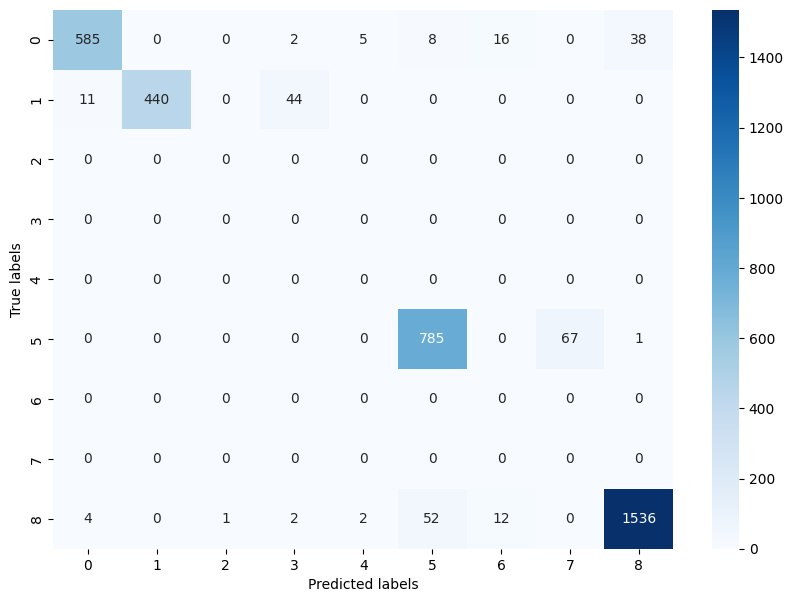

Test accuracy: 0.9266 - Test F1: 0.4182


In [21]:
accuracy, f1 = evaluate(model, test_dataloader, cm=True)
print(f"Test accuracy: {accuracy:.4f} - Test F1: {f1:.4f}")